In [1]:
# Чтобы не мешало строить графики
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Чтобы печаталось всё
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [218]:
# Импорты библиотек

import pandas as pd
import numpy as np

import math

import datetime
from datetime import datetime as dt

# для скачивания файлов
import requests 
from urllib.parse import urlencode

# статистика
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats
from scipy.stats import chi2_contingency, chi2

import statistics

import pingouin as pg

# графика
import seaborn as sns
import matplotlib.pyplot as plt

# для удобного отсчета времени
import time
from tqdm import tqdm

# Задание:
Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки```*``` при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

**Проверьте:**

Был ли эксперимент успешен в целом.

```*``` *Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.*

## Описание данных:
Всего есть три группы: **тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2)**. Для каждой из них:

```users_*.csv```– информация о пользователях:

- uid – идентификатор пользователя
- age – возраст
- attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки / просмотры * 1000)
- coins – число монеток (внутренняя валюта)
- country – страна  
- visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- gender – пол
- age_filter_start  – фильтр поиска, мин. значение 
- age_filter_end  – фильтр поиска, макс. значение 
- views_count – число полученных оценок 
- was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- is_premium –  является ли премиум
- total_revenue – нормированная выручка 

```transactions_*.csv``` – информация о платежах пользователей:

- uid – идентификатор пользователя
- country – страна
- joined_at – дата и время регистрации
- paid_at – дата и время покупки
- revenue – нормированная выручка
- payment_id – идентификатор платежа
- from_page – откуда пользователь перешел на страницу оплаты
- product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 

# О задаче

Основной вопрос (***был ли эксперимент успешен в целом?***) можно разложить на ряд второстепенных вопросов, ответы на которые дадут адекватное представление и о данных, и об эксперименте. 

Вопросы:
- Действительно ли система сплитования работала корректно, и по группам люди распределялись случайно? 
- Есть ли в данных ошибки? И если да, то насколько сильно они искажают данные?
- Достаточно ли собранных данных для подсчета метрик и поиска стат.значимых различий?
- Насколько данные репрезентативны?
- На какие метрики могло повлиять изменение? Значимо ли исследуемые метрики из тестовой группы отличаются от контрольной? 

Далее в работе я постараюсь ответить на вышеприведенные вопросы и в заключении на основе проведенного анализа дать оценку "успешности" или "неуспешности" теста в целом.

Работа будет разбита на следующие этапы:
1. загрузка и предобработка данных;
2. проверка соотвествия данных общим требованиями А/А/В тестов;
3. выделение тестовой и контрольных групп в соотвествии с условием задания;
4. расчет и сравнение метрик для А/А и A/B -тестов;
5. заключение и выводы.

# Часть 1. Загрузка и предобработка данных

In [4]:
# Функция для загрузки датасетов с Яндекс-диска
# Я заранее проверила, что разделение столбцов идет через точку с запятой, поэтому ставлю этот параметр по умолчанию

def get_data(link, separator=';'): 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=link)) # Получаю загрузочную ссылку
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url) # Загружаю файл и сохраняю его
    with open('downloaded_file.csv', 'wb') as f:  
        f.write(download_response.content) # Если ничего не указать, то файл скачается в папку, где лежит юпитер
    return(pd.read_csv('downloaded_file.csv', sep = separator))

In [5]:
# Загружаю датасеты

users_test      = get_data(link='https://disk.yandex.ru/d/4XXIME4osGrMRA')
users_control_1 = get_data(link='https://disk.yandex.ru/d/yJFydMNNGkEKfg')
users_control_2 = get_data(link='https://disk.yandex.ru/d/br6KkQupzzTGoQ')

transactions_test      = get_data(link='https://disk.yandex.ru/d/gvCWpZ55ODzs2g')
transactions_control_1 = get_data(link='https://disk.yandex.ru/d/VY5W0keMX5TZBQ')
transactions_control_2 = get_data(link='https://disk.yandex.ru/d/th5GL0mGOc-qzg')

***Небольшая ремарка***. Если будете тестировать работу кода у себя локально, то последний скачанный файл (`transactions_control_2`) сохранится в той же папке, где лежит ноутбук, под именем `downloaded_file.csv`. Это результат работы функции. Если файл больше не нужен, можно удалить его позже вручную.

**Пропущенные значения в датафреймах**

In [6]:
# Пропущенные значения в датафреймах с users

pd.DataFrame(index = users_control_1.columns.tolist(), 
             data = {'users_control_1' : users_control_1.isna().sum().tolist(), 
                    'users_control_2' : users_control_2.isna().sum().tolist(), 
                    'users_test' : users_test.isna().sum().tolist()})

,users_control_1,users_control_2,users_test
uid,0,0,0
age,0,0,0
attraction_coeff,0,0,0
coins,4280,4203,4259
country,0,0,0
visit_days,1324,1364,1330
gender,0,0,0
age_filter_start,0,0,0
age_filter_end,0,0,0
views_count,0,0,0


В группе `users` пропущенные значения есть только в 4 столбцах: `coins`, `visit_days`, `was_premium`, `is_premium`. Избавляться от NaN не стоит, их вполне можно заменить на нули. Объясню, почему. Вот, например, строкой ниже показано, что у `was_premium`и `is_premuim` есть всего одна градация (*= факт наличия премиум-подписки*), соотвественно, NaN-значения - это факт отсутсвия подписки, то есть ноль. Со столбцами `coins` и `visit_days` та же логика. Поэтому далее просто меняю все NaN-значения на нули.

In [7]:
# Подтверждение, что у was_premium и is_premium только одна градация

users_test.agg({'was_premium':'nunique', 'is_premium':'nunique'})

was_premium    1
is_premium     1
dtype: int64

In [8]:
# Меняю NaN на нули (у 'visit_days' поменяю NaN позже):

for x in [users_test, users_control_1, users_control_2]:
    x['coins'] = x.coins.fillna(0)
    x['was_premium'] = x.was_premium.fillna(0)
    x['is_premium'] = x.is_premium.fillna(0)

In [9]:
# Пропущенные значения в датафреймах с transactions

pd.DataFrame(index = transactions_control_1.columns.tolist(), 
             data = {'transactions_control_1' : transactions_control_1.isna().sum().tolist(), 
                     'transactions_control_2' : transactions_control_2.isna().sum().tolist(), 
                     'transactions_test' : transactions_test.isna().sum().tolist()})

,transactions_control_1,transactions_control_2,transactions_test
uid,630,0,0
country,630,0,0
joined_at,0,0,0
paid_at,0,0,0
revenue,630,0,0
payment_id,630,0,0
from_page,630,0,0
product_type,630,0,0


Теперь перейду к группе `transactions`. Только в датасете `transactions_control_1` наблюдаются NaN. Причем значения пропущены полностью по всем столбцам (`joined_at` и `paid_at` считаны как строки, соотвественно, Nan считан тоже как строка). В строке ниже я покажу это на самом датасете. 

Единственно приемлемым решением мне представляется удаление этих строк.

In [10]:
# Вот так нагляднее: пропущенные строки в transactions_control_1

transactions_control_1[transactions_control_1.uid.isna()].head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
377,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
378,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
379,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [11]:
# Удаляю пропущенные строки
transactions_control_1 = transactions_control_1.dropna()

In [12]:
# Размеры датафреймов

pd.DataFrame(index = ['users_test', 'users_control_1', 'users_control_2', 
                      'transactions_test', 'transactions_control_1', 'transactions_control_2'], 
             data = {'shape' : [users_test.shape[0], users_control_1.shape[0], users_control_2.shape[0],
                               transactions_test.shape[0], transactions_control_1.shape[0], transactions_control_2.shape[0]]})

,shape
users_test,4308
users_control_1,4340
users_control_2,4264
transactions_test,273
transactions_control_1,377
transactions_control_2,328


Размеры датафреймов сильно различаются, то есть если их смерджить, потеряется существенная часть данных. 

In [13]:
# Но сначала проверю, действительно ли уникальны значения uid в users

users_test.uid.nunique()      == users_test.shape[0]
users_control_1.uid.nunique() == users_control_1.shape[0]
users_control_2.uid.nunique() == users_control_2.shape[0]

True

True

True

Да, в каждом из датафреймов группы `users` `uid` уникальны. Это значит, что в `transactions` учитываются далеко не все `uid`, что очень логично - ведь не все пользователи приложения что-то покупали. Однако для крупного дейтингового приложения по 200-300 транзакций на каждую группу все равно, мне кажется, маловато.

Также на всякий случай стоит проверить, не пересекаются ли группы друг с другом. Строкой ниже я это проверяю ---> нет, во всех группах юзеры уникальны, пересечений нет, что уже хорошо.

In [14]:
# Проверяю, есть ли такие юзеры, которые случайно могли попасть в две разные группы. Если ноль, то всё ок

sum([True if x in users_control_1.uid.tolist() else False for x in users_test.uid.tolist()])
sum([True if x in users_control_2.uid.tolist() else False for x in users_test.uid.tolist()])
sum([True if x in users_control_1.uid.tolist() else False for x in users_control_2.uid.tolist()])

0

0

0

**Формат данных.** Здесь я сразу вижу две проблемы: нечитаемый строковый формат в `visit_days` и *object* у столбцов `joined_at` и `paid_at`. Всё это легко исправить.

In [15]:
# Типы данных в датафреймах с users

pd.DataFrame(index = users_control_1.columns.tolist(), 
             data = {'users_control_1' : list(users_control_1.dtypes.values), 
                    'users_control_2' : list(users_control_2.dtypes.values), 
                    'users_test' : list(users_test.dtypes.values)})

,users_control_1,users_control_2,users_test
uid,int64,int64,int64
age,int64,int64,int64
attraction_coeff,int64,int64,int64
coins,float64,float64,float64
country,object,object,object
visit_days,object,object,object
gender,int64,int64,int64
age_filter_start,int64,int64,int64
age_filter_end,int64,int64,int64
views_count,int64,int64,int64


In [16]:
# Типы данных в датафреймах с transactions

pd.DataFrame(index = transactions_control_1.columns.tolist(), 
             data = {'transactions_control_1' : list(transactions_control_1.dtypes.values), 
                     'transactions_control_2' : list(transactions_control_2.dtypes.values), 
                     'transactions_test' : list(transactions_test.dtypes.values)})

,transactions_control_1,transactions_control_2,transactions_test
uid,float64,int64,int64
country,object,object,object
joined_at,object,object,object
paid_at,object,object,object
revenue,float64,int64,int64
payment_id,float64,int64,int64
from_page,object,object,object
product_type,object,object,object


In [17]:
# Преобразую столбцы с датами в тип datetime

for x in [transactions_test, transactions_control_1, transactions_control_2]:
    x['joined_at'] = pd.to_datetime(x.joined_at)
    x['paid_at'] = pd.to_datetime(x.paid_at)

In [18]:
# Преобразую в список с int столбец visit_days во всех датафреймах users

for x in [users_test, users_control_1, users_control_2]:
    result = []
    for i in x.visit_days:
        try:
            result.append([int(e) for e in re.findall('\d', i)])
        except:
            result.append(None)
    x['visit_days'] = result

In [19]:
# Удаляю пропущенные значения у visit_days

for x in [users_test, users_control_1, users_control_2]:
    x['visit_days'] = x.visit_days.fillna(0)

**Дублирующиеся строки**

In [20]:
# Есть ли в данных дубликаты?

print(f"""
Дубликаты у users_test:      {users_test[users_test.columns.difference(['visit_days'])].duplicated().any()}
Дубликаты у users_control_1: {users_control_1[users_control_1.columns.difference(['visit_days'])].duplicated().any()} 
Дубликаты у users_control_2: {users_control_2[users_control_2.columns.difference(['visit_days'])].duplicated().any()} 

------------------------------------

Дубликаты у transactions_test:      {transactions_test.duplicated().any()}
Дубликаты у transactions_control_1: {transactions_control_1.duplicated().any()}
Дубликаты у transactions_control_2: {transactions_control_2.duplicated().any()}""")


Дубликаты у users_test:      False
Дубликаты у users_control_1: False 
Дубликаты у users_control_2: False 

------------------------------------

Дубликаты у transactions_test:      True
Дубликаты у transactions_control_1: True
Дубликаты у transactions_control_2: True


Дублирующиеся строки были найдены только у датафреймов `transactions`. Сначала посмотрю, сколько их, потом удалю. 

In [21]:
print(f"""
Дубликаты у transactions_test:      {transactions_test.duplicated().sum()}; {transactions_test.duplicated().sum()/transactions_test.shape[0]*100}%
Дубликаты у transactions_control_1: {transactions_control_1.duplicated().sum()}; {transactions_control_1.duplicated().sum()/transactions_control_1.shape[0]*100}%
Дубликаты у transactions_control_2: {transactions_control_2.duplicated().sum()}; {transactions_control_2.duplicated().sum()/transactions_control_2.shape[0]*100}%
""")


Дубликаты у transactions_test:      7; 2.564102564102564%
Дубликаты у transactions_control_1: 21; 5.570291777188329%
Дубликаты у transactions_control_2: 5; 1.524390243902439%



Количество дублирующихся строк незначительно в `test` и `control_2`, однако в `control_1` их реально много - 5% от датасета. Я здесь сразу вижу проблему, но она не в самом дублировании, а в факте того, что `total_revenue` в `users` высчитывался по `revenue` из `transactions`. И если удалить дублирующиеся строки, то значения не будут биться между собой. 

В данном случае можно либо пересчитать `total_revenue` для юзеров с дублирующимися строками, либо просто оставить все как есть (*если значения не сильно отличаются, то второй вариант оптимальный*). 

Важно то, что это системная проблема: еще на этапе отбора данных надо отсеивать дубликаты и только потом считать `total_revenue` в `users`. *Сейчас покажу это на примере.*

In [22]:
print(f'''
Возьму uid с наибольшим количеством дубликатов из самой проблемной группы transactions_control_1.
Это uid = {transactions_control_1[transactions_control_1.duplicated()].groupby('uid').paid_at.count().idxmax()}
Его total_revenue, посчитанный по revenue в transactions_control_1: {transactions_control_1[transactions_control_1.uid == 892333905.0].revenue.sum()}
Совпадает ли с total_revenue из users_control_1?: {(transactions_control_1[transactions_control_1.uid == 892333905.0].revenue.sum() == users_control_1[users_control_1.uid == 892333905.0].total_revenue).values[0]}
Да, совпадает.

А теперь уберу дубликаты и снова проверю: {(transactions_control_1[transactions_control_1.uid == 892333905.0].drop_duplicates().revenue.sum() == users_control_1[users_control_1.uid == 892333905.0].total_revenue).values[0]}
Вот теперь не совпадает. Пересчитанный total_revenue: {transactions_control_1[transactions_control_1.uid == 892333905.0].drop_duplicates().revenue.sum()}

Насколько сильно отличается пересчитанное значение от изначального?
Пересчитанное значение по отношению к исходному уменьшилось на {
( ( transactions_control_1[transactions_control_1.uid == 892333905.0].revenue.sum() - 
    transactions_control_1[transactions_control_1.uid == 892333905.0].drop_duplicates().revenue.sum() ) / 
    transactions_control_1[transactions_control_1.uid == 892333905.0].revenue.sum() * 100 )}%''')


Возьму uid с наибольшим количеством дубликатов из самой проблемной группы transactions_control_1.
Это uid = 892333905.0
Его total_revenue, посчитанный по revenue в transactions_control_1: 486330.0
Совпадает ли с total_revenue из users_control_1?: True
Да, совпадает.

А теперь уберу дубликаты и снова проверю: False
Вот теперь не совпадает. Пересчитанный total_revenue: 403104.0

Насколько сильно отличается пересчитанное значение от изначального?
Пересчитанное значение по отношению к исходному уменьшилось на 17.1130713712911%


Конечно, в примере выше показан самый экстремальный случай. У других `uid`, уверена, расхождения меньше. Считаю, все же лучше пересчитать `total_revenue` по дублирующимся `uid`, их все равно не так много.

In [24]:
# Записываю uid из дублирующихся строк в список 

test_dup_uid      = transactions_test[transactions_test.duplicated()].uid.tolist()
control_1_dup_uid = transactions_control_1[transactions_control_1.duplicated()].uid.tolist()
control_2_dup_uid = transactions_control_2[transactions_control_2.duplicated()].uid.tolist()

In [25]:
# Удаляю дубликаты

transactions_test      = transactions_test.drop_duplicates(keep='first')
transactions_control_1 = transactions_control_1.drop_duplicates(keep='first')
transactions_control_2 = transactions_control_2.drop_duplicates(keep='first')

In [26]:
# Меняю значения в столбце total_revenue

# Создаю вспомогательные датафреймы (потом их удалю)
tr_test_repl      = (transactions_test.drop_duplicates().query('uid in @test_dup_uid')
                     .groupby('uid', as_index=False).agg({'revenue':'sum'})
                     .rename(columns={'revenue':'sum_rev'}))
tr_control_1_repl = (transactions_control_1.drop_duplicates().query('uid in @test_dup_uid')
                     .groupby('uid', as_index=False).agg({'revenue':'sum'})
                     .rename(columns={'revenue':'sum_rev'}))
tr_control_2_repl = (transactions_control_2.drop_duplicates().query('uid in @test_dup_uid')
                     .groupby('uid', as_index=False).agg({'revenue':'sum'})
                     .rename(columns={'revenue':'sum_rev'}))

# Меняю значения (создаю дополнительный столбец, не перезаписываю все в total_revenue)
users_test = users_test.merge(tr_test_repl, on='uid', how='left')
users_test['total_revenue_corrected'] = [users_test.total_revenue[x] if math.isnan(users_test.sum_rev[x]) else users_test.sum_rev[x] for x in range(users_test.shape[0])]
users_test = users_test.drop('sum_rev', axis=1)

users_control_1 = users_control_1.merge(tr_control_1_repl, on='uid', how='left')
users_control_1['total_revenue_corrected'] = [users_control_1.total_revenue[x] if math.isnan(users_control_1.sum_rev[x]) else users_control_1.sum_rev[x] for x in range(users_control_1.shape[0])]
users_control_1 = users_control_1.drop('sum_rev', axis=1)

users_control_2 = users_control_2.merge(tr_control_2_repl, on='uid', how='left')
users_control_2['total_revenue_corrected'] = [users_control_2.total_revenue[x] if math.isnan(users_control_2.sum_rev[x]) else users_control_2.sum_rev[x] for x in range(users_control_2.shape[0])]
users_control_2 = users_control_2.drop('sum_rev', axis=1)

# И удаляю уже ненужные вспомогательные датафреймы и списки
del tr_test_repl, tr_control_1_repl, tr_control_2_repl
del test_dup_uid, control_1_dup_uid, control_2_dup_uid

# Часть 2. Обработка данных в соотвествии с общими требованиями А/А/В-тестирования

### 2.1. Общие требования
Поскольку чистота эксперимента зависит от отсутсвия какого-либо стороннего влияния, кроме влияния исследуемого изменения, необходимо, чтобы данные в группах согласовались по следующим критериям:
- данные собраны за один и тот же период;
- география исследования совпадает;
- распределение групп по основным характеристикам (кроме исследуемых) тоже должно совпадать (*например, соотношение по полу, распределение по возрасту и т.д.*)
- и, наконец, отбор людей по группам должен происходить случайно (этот пункт в основную часть не войдет).

In [27]:
# Добавляю маркировку к каждой группе

transactions_test['group']      = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'

# И для удобства объединяю все в один датафрейм
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2], ignore_index=True)

**Хронологический критерий.** На scatterplot(-е) ниже видно, что большинство пользователей попали в 2017 г., видимо тогда и проводился эксперимент. Однако один пользователь из 2015-го по ошибке попал в контрольную группу 1 (*нижний левый угол, оранжевая точка*).

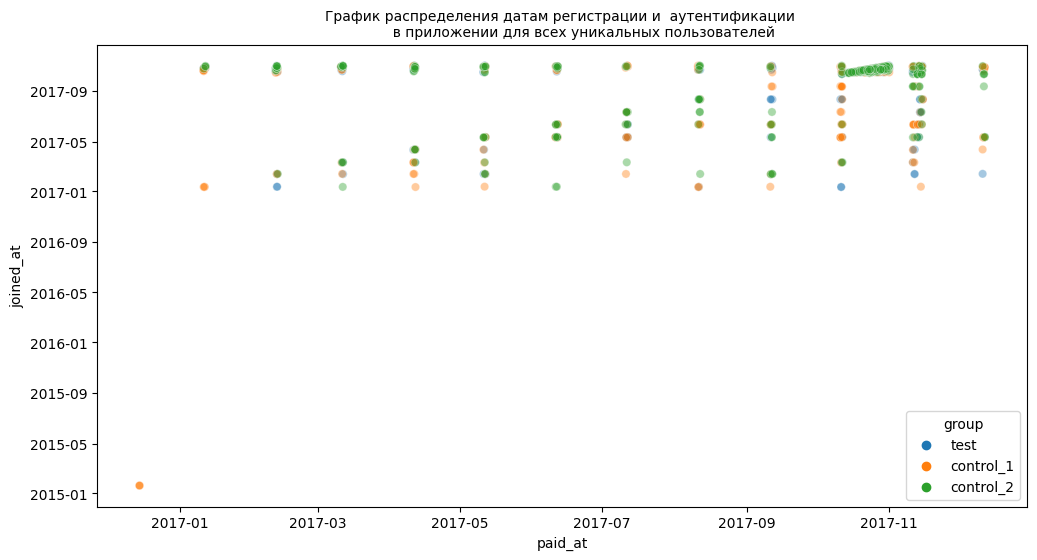

In [28]:
plt.figure(figsize=(12, 6))
plt.title(f'''График распределения датам регистрации и  аутентификации 
          в приложении для всех уникальных пользователей''', fontsize=10)
sns.scatterplot(data=transactions, x='paid_at', y='joined_at', hue='group', alpha=.4);

In [29]:
# Действительно, вот этот юзер:
transactions[transactions.paid_at.dt.year < 2017] 

# Далее хочу проверить, был ли он единственным человеком из 2015 года (второй output)
transactions[transactions.joined_at.dt.year == 2015] == transactions[transactions.paid_at.dt.year < 2017]
# Да, это так

# Что ж, удалю этого юзера, т.к. он не вписывается во временные рамки эксперимента
uid_to_del = transactions[transactions.joined_at.dt.year == 2015].uid.head(1).values[0]

# Перезаписываю датафреймы, исключив этого юзера
transactions = transactions[transactions.uid != uid_to_del]
users_control_1 = users_control_1[users_control_1.uid != uid_to_del]

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
330,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,control_1
364,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,control_1
481,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,control_1


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
330,True,True,True,True,True,True,True,True,True
364,True,True,True,True,True,True,True,True,True
481,True,True,True,True,True,True,True,True,True


Проверяя даты регистрации и заходов в приложение, я случайно обнаружила, что есть такие пользователи, у которых `paid_at` идет по времени позже, чем `joined_at`. Таких пользователей было довольно много, и, честно говоря, мне не хотелось их сразу удалять. Далее через код покажу, почему я решила их оставить. 

In [30]:
print(f'''Если исключить из датасета пользователей с неправильным paid_at, то придется отбросить {(1 - (sum(transactions.joined_at <= transactions.paid_at) / transactions.shape[0]))*100}% данных''')

print(f'''А вот столько придется выбросить по группам в абсолютном отношении:''')
transactions[transactions.joined_at > transactions.paid_at].groupby('group', as_index=False).uid.nunique()

Если исключить из датасета пользователей с неправильным paid_at, то придется отбросить 17.19745222929936% данных
А вот столько придется выбросить по группам в абсолютном отношении:


,group,uid
0,control_1,37
1,control_2,41
2,test,35


In [31]:
# Смотрю, что это за данные
transactions[transactions.joined_at > transactions.paid_at].paid_at.head(10)

11   2017-10-11 19:00:00
20   2017-03-11 10:57:00
24   2017-03-11 20:20:00
25   2017-08-11 01:56:00
36   2017-09-11 15:44:00
37   2017-04-11 00:59:00
38   2017-08-11 22:45:00
47   2017-06-11 17:31:00
55   2017-06-11 11:51:00
57   2017-04-11 11:09:00
Name: paid_at, dtype: datetime64[ns]

In [32]:
# Таких строк всего:
sum(transactions.joined_at > transactions.paid_at)

162

Уже сейчас кажется странным, что часто встречается один и тот же день - 11-е число. Самое простое объяснение: в данных изначально ошибка (наверное, даты записывались в `datetime`, потом конвертировались в строки и для какой-то части `%m` и `%d` перепутались местами в `.strftime`). То есть, месяц - это число, а число - месяц.

In [33]:
# Действительно, нет никаких других дней, кроме 11-го:
(transactions[transactions.joined_at > transactions.paid_at].paid_at.dt.day != 11).sum()

0

Не вижу других вариантов, кроме как исправить эти строки.

In [34]:
new_dt_lst = [] # список для новых дат

# Перевожу даты в строку, поменяв месяц с днем
for x in range(transactions.shape[0]):
    if (transactions.joined_at.iloc[x] > transactions.paid_at.iloc[x]):
        new_dt_lst.append(transactions.paid_at.iloc[x].strftime('%Y-%d-%m %H:%M:%S'))
    else: 
        new_dt_lst.append(transactions.paid_at.iloc[x].strftime('%Y-%m-%d %H:%M:%S'))

# Добавляю новый столбец для исправленных дат (paid_at не хочу трогать)      
transactions['paid_at_corrected'] = new_dt_lst
transactions['paid_at_corrected'] = pd.to_datetime(transactions.paid_at_corrected, format='%Y-%m-%d %H:%M:%S')

In [35]:
# Проверю, остались ли проблемные записи

sum(transactions.joined_at > transactions.paid_at_corrected)
# Нет, таких не осталось

0

**Географический критерий.** Регионы исследования должны совпадать.

In [36]:
# Уникальные страны по группам

transactions.groupby('group', as_index=False).country.nunique()

,group,country
0,control_1,17
1,control_2,19
2,test,17


Количество стран по группам не совпадает и еще неизвестно, совпадают ли сами страны между собой. К сожалению, придется выкинуть часть данных и оставить только те страны, которые есть во всех датафреймах. 

Ориентироваться буду уже сразу на датафреймы с `transactions`, а не `users`. Неизвестно, влияет ли географическое положение на намерение пользователя купить премиум, поэтому, если в дальнейшем весь анализ будет базироваться на `transactions`, то логично отфильтровать людей именно по ним. 

In [37]:
# Напишу лучше функцию для поиска совпадающих стран, она может еще понадобиться

def find_common_countries(test, control_1, control_2):
    
    # Создаю списки со странами на основе датафреймов

    countries_test      = test.country.unique().tolist()
    countries_control_1 = control_1.country.unique().tolist()
    countries_control_2 = control_2.country.unique().tolist()
    
    # Ищу общие страны   
    
    countries_t_c1 = [] # между тестовой и контрольной_1
    for x in countries_test:
        if x in countries_control_1:
            countries_t_c1.append(x)

    common_countries_lst = [] # ищу совпадения с контрольной_2
    for x in countries_t_c1:
        if x in countries_control_2:
            common_countries_lst.append(x)
            
    return(common_countries_lst)

In [38]:
# Применяю функцию

countries_lst = find_common_countries(test = transactions.query('group=="test"'),
                      control_1 = transactions.query('group=="control_1"'),
                      control_2 = transactions.query('group=="control_2"'))
print(f'''
Всего общих стран: {len(countries_lst)}
Придется удалить: {(1 - (transactions.country.isin(countries_lst).sum() / transactions.shape[0])) * 100}% строк
''')

transactions = transactions[transactions.country.isin(countries_lst)] # и перезаписываю transactions, здесь страны пересекаются


Всего общих стран: 15
Придется удалить: 3.0785562632696384% строк



**Соотношение распределений по основным характеристикам.** Здесь главная задача посмотреть, чтобы распределения по независимым характеристикам (*в данном случае, это возраст, пол, лайки и прочее*) пользователей были более-менее одинаковы.

In [39]:
# Объединяю пользователей в один датафрейм и мерджу его с transactions,
# я заранее проверила, что страны по uid у двух датафреймов идентичны, поэтому у юзеров просто дропнула этот столбец

# Все это нужно для того, чтобы добавить характеристики из users

transactions = transactions.merge(pd.concat([users_test, users_control_1, users_control_2], 
                                            ignore_index=True).drop('country', axis=1), on='uid', how='left')

*Возраст.* По этому принзаку группы распределены более-менее равномерно. Внимание сразу привлекают выбросы в `test` и `control_1`: очевидно, что, поставив возраст 99+, пользователь просто хотел скрыть свой возраст. На покупку премиума выбросы никак не влияют, однако среднее значение из-за них подтягивается вверх. В целом, если это общая тенденция, то разницы в дисперсиях мы не увидим. 

Есть два решения этой проблемы: заменить слишком высокие значения на NaN или оставить все как есть. Поскольку нет задачи исследовать возраст, думаю, можно оставить все как есть.

На графике плотности распределения (kde-plot) пользователи распределяются похожим образом, за исключением вышеупомянутых выбросов. 

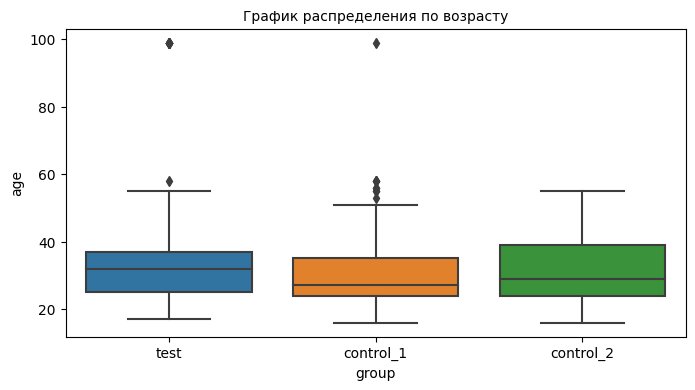

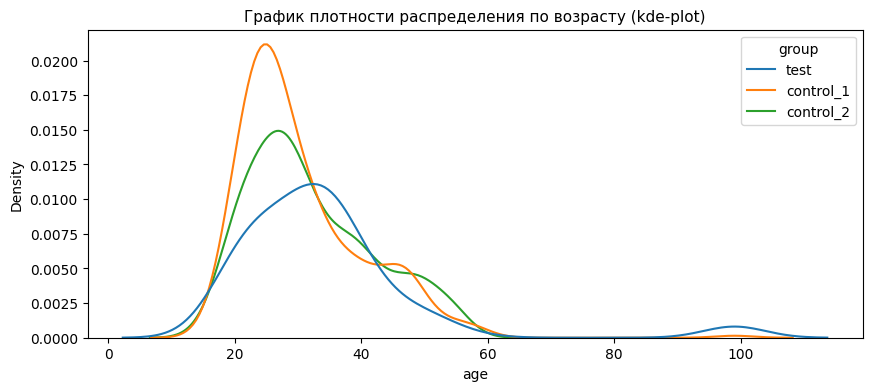

In [43]:
plt.figure(figsize=(8, 4))
plt.title('График распределения по возрасту', fontsize=10)
sns.boxplot(data=transactions, x='group', y='age');

plt.figure(figsize=(10, 4))
plt.title('График плотности распределения по возрасту (kde-plot)', fontsize=11)
sns.kdeplot(data=transactions, x='age', hue='group');

In [44]:
# Конечно, распределение на гистограмме кажется равномерным, но на всякий случай проверю тестом Левена
pg.homoscedasticity(transactions, dv='age', group='group', method='levene', alpha=0.05)
# Всё ок, дисперсии групп по возрасту равны

,W,pval,equal_var
levene,2.821653,0.060028,True


*Лайки, просмотры.* Другие неисследуемые количественные признаки тоже не должны отличаться, что проверено ячейкой ниже.

In [45]:
print(f'''Проверю еще на однородность дисперсий следующие показатели:
attraction_coeff: {pg.homoscedasticity(transactions, dv='attraction_coeff', group='group', method='levene', alpha=0.05)['equal_var'].values[0]}
views_count:      {pg.homoscedasticity(transactions, dv='views_count', group='group', method='levene', alpha=0.05)['equal_var'].values[0]}''')

Проверю еще на однородность дисперсий следующие показатели:
attraction_coeff: True
views_count:      True


*Пол.* По половому признаку выборки распределены очень неравномерно. Не могу точно сказать, есть ли значимые различия между группами (у `gender-0` слишком мало наблюдений, чтобы использовать Хи-квадрат даже с поправкой Йейтса). В силу того, что у всех групп большая часть наблюдений представлена для `gender-1`, рискну предположить, что в отношении пола распределения по группам похожи. Для большей наглядности я сделала барплот по этим данным.

In [46]:
# Соотношение по полу в таблице сопряженности
crosstab_gender = transactions.groupby(['group', 'gender'], as_index=False).agg({'uid':'nunique'}).pivot(columns='gender', index='group').droplevel(0, axis=1)
crosstab_gender

gender,0,1
group,,
control_1,4,184
control_2,7,171
test,2,142


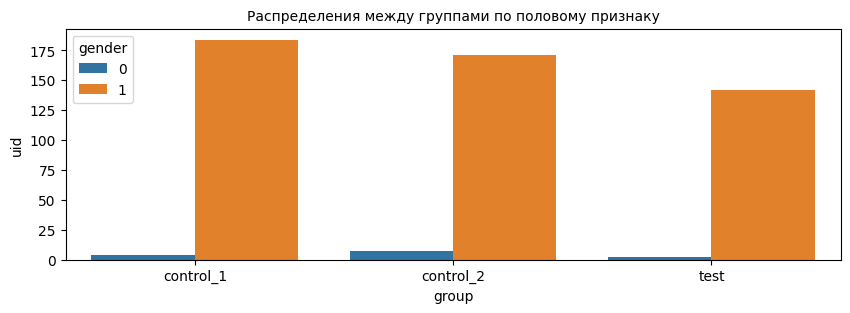

In [47]:
plt.figure(figsize=(10, 3))
plt.title('Распределения между группами по половому признаку', fontsize=10)
sns.barplot(data=transactions.groupby(['group', 'gender'], as_index=False).agg({'uid':'nunique'}), 
            x='group', hue='gender', y='uid');

### 2.2. Дополнительные требования из задания
Теперь стоит рассмотреть дополнительные требования, поставленные в задании. Еще раз приведу текст:

>Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого **для новых пользователей** из **нескольких стран** была изменена стоимость премиум-подписки* **при покупке через две новые платежные системы**. При этом стоимость пробного периода оставалась прежней.

***Я здесь вижу 3 специальных условия:***
1. **Это новые пользователи.** Думаю, здесь подразумеваются новые зарегистрированные пользователи.
3. **Которые использовали только две платежные системы.** Нужно определить, какие именно.
2. **В экперименте участвовали не все страны.** Надо исключить те, что не участвовали.

Требование по ***новым пользователям*** было выполнено еще в предыдущем разделе, где я убрала человека из 2015 года. Но мне еще тогда показалось странным скопление точек на в октябре-ноябре 2017 г.  Если это и есть "новые" пользователи, то эксперимент шел где-то месяц-два, но не год (что очень даже логично, за год набралось бы намного больше данных).

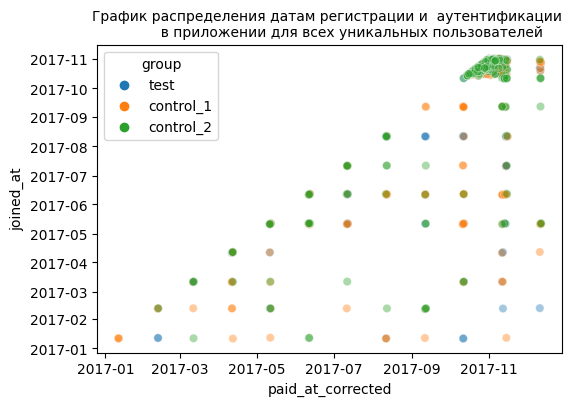

In [48]:
# Повторю еще раз график, он сразу показался странным из-за скопления точек в октябре

plt.figure(figsize=(6, 4))
plt.title(f'''График распределения датам регистрации и  аутентификации 
          в приложении для всех уникальных пользователей''', fontsize=10)
sns.scatterplot(data=transactions, x='paid_at_corrected', y='joined_at', hue='group', alpha=.4);

Действительно, на октябрь 2017 приходится 72% всех оставшихся записей. Думаю, в этот месяц проводился А/Б-тест.

In [49]:
# Сколько записей приходится на октябрь?

sum(transactions.joined_at.dt.month == 10) / transactions.shape[0]

0.7174151150054765

In [50]:
# Распределение по группам в октябре:

transactions[transactions.joined_at.dt.month == 10].groupby('group').uid.nunique()

group
control_1    116
control_2    129
test          99
Name: uid, dtype: int64

Но можно ли абсолютно точно сказать, что данные собирались в октябре? О деталях эксперимента неизвестно ничего, кроме того, что цена на подписку-премиум изменилась (непонятно даже, в какую сторону). Думаю, надо отследить как менялась средняя стоимость подписки-премиум в контрольных и тестовой группах на протяжении года по месяцам. И если средняя цена изменится в тестовой группе в октябре (по отношению к контрольным группам), то мое предположение о времени эксперимента и о том, кого считать "новыми пользователями", подтвердится.

Что ж ... рискну это проверить, еще не отсеив платежные системы.

In [51]:
# Считаю среднюю цену по группам, учитывая только подписку premium_no_trial

t = ( transactions.query('product_type=="premium_no_trial" & group=="test"')
    .resample(rule='M', on='paid_at_corrected').agg({'revenue':'sum', 'uid':'nunique'}) )
t['test'] = t.revenue / t.uid
t = t.drop(['revenue', 'uid'], axis=1)

c1 = ( transactions.query('product_type=="premium_no_trial" & group=="control_1"')
    .resample(rule='M', on='paid_at_corrected').agg({'revenue':'sum', 'uid':'nunique'}) )
c1['control_1'] = c1.revenue / c1.uid
c1 = c1.drop(['revenue', 'uid'], axis=1)

c2 = ( transactions.query('product_type=="premium_no_trial" & group=="control_2"')
    .resample(rule='M', on='paid_at_corrected').agg({'revenue':'sum', 'uid':'nunique'} )
   )
c2['control_2'] = c2.revenue / c2.uid
c2 = c2.drop(['revenue', 'uid'], axis=1)


new_data = pd.concat([t,c1,c2], axis=1).reset_index() # собираю все в один датафрейм

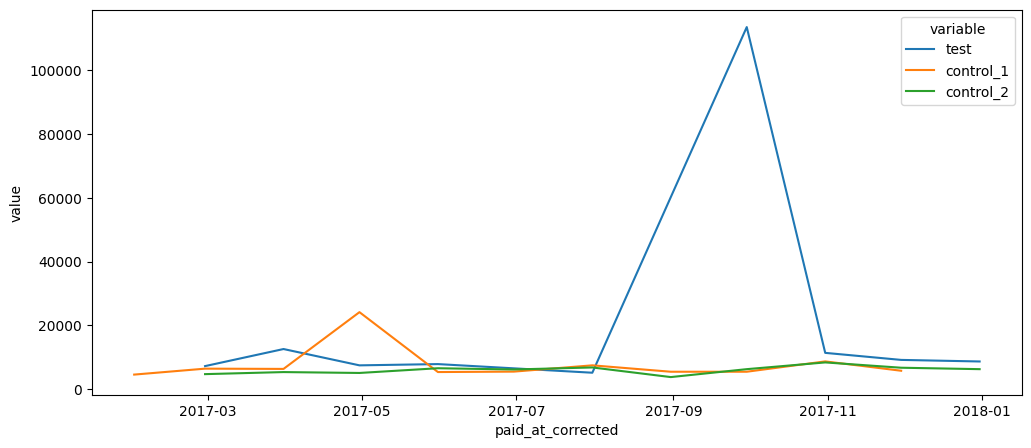

In [52]:
# Отрисовка графика:

plt.figure(figsize=(12,5))
sns.lineplot(x='paid_at_corrected', y='value', hue='variable', data=pd.melt(new_data, ['paid_at_corrected']));

На графике виден пик у тестовой группы именно в октябре. Мое предположение подтвердилось: А/А/В тест проводился в октябре 2017. Еще из графика можно вынести, что цену подписки у тестовой группы повысили, и, следовательно, новые пользователи - это те, кто зарегистрировался в октябре.

Теперь перейду к ***платежным системам.*** Сначала выведу все возможные системы по подписке premium_no_trial для тех, кто присоединился в октябре.

In [53]:
( transactions[transactions.joined_at.dt.month == 10].query('product_type=="premium_no_trial"')
    .groupby(['group', 'payment_id'])
    .agg({'uid':'nunique', 'paid_at':'count'}) )

uid  paid_at
group     payment_id              
control_1 0.0           1        1
          68.0         10       11
          147.0        50       52
control_2 68.0          4        4
          147.0        61       65
test      0.0           1        1
          68.0          5        9
          147.0        41       45

Нашлось три системы, а не две. Но если посмотреть внимательнее, то можно заметить, что в системе "0" платило всего 2 человека за исследуемый период. Плюс, надо учесть, это эти 2 человека есть только в контроле-1 и в тестовой группе. Думаю, система "0" попала сюда случайно, и ее можно отбросить.

Далее я отберу пользователей только из систем 68 и 147 (которые зарегистрировались в октябре) и создам для них новый датафрейм. 

In [54]:
# Перезаписываю все в новый датафрейм

# На всякий случай 'uid' с отобранными 'payment_id' перезапишу в новый датафрейм, а transactions оставлю нетронутым
# Фильтрацию с условием premium_no_trial специально не включаю, т.к. человек мог и не купить премиум 
# (важно, чтобы у него просто была такая возможность)

data = transactions[transactions.joined_at.dt.month == 10].query('payment_id in [68,147]')

И последний шаг - отобрать ***подходящие страны.*** Кроме требования совпадения всех стран по всем группам других условий у меня нет. Поэтому далее отберу страны по этому критерию.

In [55]:
# Собираю совпадающие страны по новым отфильтрованным данным с помощью ранее написанной функции

countries_list = find_common_countries(test=data.query('group=="test"'), 
                     control_1=data.query('group=="control_1"'), 
                     control_2=data.query('group=="control_2"'))

print(f'''
Все ли страны совпали?: {data.country.nunique() == len(countries_list)}
Сколько тогда стран выпало?: {data.country.nunique() - len(countries_list)}
Придется удалить: {(1 - (data.country.isin(countries_list).sum() / data.shape[0])) * 100}% строк
''')

# Фильтрую data по странам
data = data[transactions.country.isin(countries_list)]


Все ли страны совпали?: False
Сколько тогда стран выпало?: 2
Придется удалить: 2.5723472668810254% строк



In [56]:
# Уникальные страны записываю в отдельный список, так потом удобнее будет к нему обращаться

right_countries_lst = data.country.unique().tolist()
print(f'''Всего стран: {len(right_countries_lst)}''')
right_countries_lst

Всего стран: 13


['United States of America',
 'Canada',
 'United Arab Emirates',
 'Argentina',
 'Spain',
 'United Kingdom (Great Britain)',
 'France',
 'Italy',
 'Belgium',
 'Israel',
 'Chile',
 'Australia',
 'Germany']

In [57]:
# Уникальные пользователи и их платежи

data.groupby('group').agg({'uid':['nunique', 'count']})

uid      
          nunique count
group                  
control_1      99   103
control_2     101   105
test           86    95

In [58]:
# Итоговый датафрейм

transactions_october = transactions[(transactions.joined_at.dt.month >= 10) &
             (transactions.paid_at_corrected.dt.month <= 12)].query('country in @right_countries_lst & payment_id in [68,147]')

**Итоговый датафрейм** отфильтрован по следующим условиям:
- время действия эксперимента - с октября`*` (и покупки, и регистрация считаются с октября и до конца года); 
- в нем только страны, участвующие в эксперименте;
- данные отфильтрованы по двум платежным системам.

`*` *Небольшое пояснение по определению времени эксперимента.* На графике выше было показано, как средняя стоимость подписки `premium_no_trial` резко выросла у тестовой группы. Это дало мне основание считать, что экперимент проводили именно в октябре. Далее в ноябре средняя цена за подписку `premium_no_trial` у тестовой группы падает до уровня контрольных групп, но я все равно ноябрь и декабрь включаю в выборку, почему? 

Во-первых, в получившемся датафрейме последняя регистрация пользователя была 31 октября, так что, формально, в последующие месяцы будут учтены покупки тех, кто присоединился в октябре. 

Во-вторых, в задании не указано, сколько времени длился A/B-тест. Маловероятно, что тест длился год: на некоторые месяцы по каждой из групп ну очень мало записей. Столь же маловероятным мне кажется, что тест проводили только один месяц - в октябре. Странно было бы менять стоимость премиума для на новых пользователей на один месяц, а потом откатывать изменение назад и продолжать собирать данные в тестовую группу. 

Учитывая все вышесказанное, мне показалось разумным определить время эксперимента с октября по декабрь (включительно).

In [59]:
# Подтверждение, что максимальная дата регистрации пользователя - 31 октября

transactions_october.joined_at.max()

Timestamp('2017-10-31 23:40:00')

# Часть 3. Проверка результатов А/А/B-теста
Из имеющихся у меня данных можно проверить на стат.значимость две метрики: **ARPPU** (наиболее подходящий метод: *t-test*) и **конверсию в покупку премиума** (метод: *Хи-квадрат*). Изменение метрики будет считаться стат.значимым, а тест - успешным, если тест не найдет значимых отличий между контрольными группами, но найдет такие различия между контрольной и тестовой группами. За порог значимости приму общепринятую величину, `α = 0.05`.
### Конверсия в премиум
Для подсчета конверсии я разделю пользователей на тех, кто купил подписку-премиум (тип `premium_no_trial`), и тех, кто этого не сделал. При этом здесь будет неважно, сколько раз человек обновлял подписку (и обновлял ли ее воообще). Если новый пользователь хоть раз купил премиум за время проведения эксперимента, то он будет считаться "сконвертировавшимся". Для проверки метрики буду использовать **критерий Хи-квадрат**.

Но сначала я промаркирую пользователей.

In [60]:
# Список тех, кто купил премиум

uid_bought_premium_lst = transactions_october.query('product_type=="premium_no_trial"').uid.tolist()

In [61]:
# В новом столбце присваиваю 1 тем, кто купил премиум

transactions_october['bought_premium'] = [1 if transactions_october.uid.iloc[x] in uid_bought_premium_lst else 0 for x in range(transactions_october.shape[0])]

Далее сравню распределение по двум контрольным группам.

**Гипотезы для А/А-теста:**
- $H_0$: статистически значимых различий нет; 
- $H_1$: статистически значимые различия есть.

In [62]:
crosstab = (transactions_october.query('group!="test"')
    .groupby(['bought_premium', 'group'], as_index=False).agg({'uid':'nunique'})
    .pivot(columns='bought_premium', index='group').droplevel(0, axis=1))

crosstab # матрица

statistic, pvalue, dof, expected_freq = scipy.stats.chi2_contingency(crosstab)
print(f'''statistic: {statistic}, pvalue: {pvalue}''')

bought_premium,0,1
group,,
control_1,42,57
control_2,39,62


statistic: 0.16385288285027308, pvalue: 0.6856337516813173


Значение `p-value` сильно выше допустимого порога 0.05. Это говорит о том, что между двумя контрольными группами значимых различий не обнаружить не удалось, А/А-тест прошел успешно. 

Теперь перейду в А/В-тесту: сравню обе контрольные группы с тестовой. Если тест покажет значимый результат, то изменение цены подписки действительно повлияло на метрику. Соответственно, если результат незначим - то никакого эффекта от изменения нет (либо он настолько мал, что его сложно задетектить).

**Гипотезы для А/В-теста:**
- $H_0$: статистически значимых различий нет; 
- $H_1$: статистически значимые различия есть.

In [63]:
crosstab_1 = (transactions_october.groupby(['bought_premium', 'group'], as_index=False)
    .agg({'uid':'nunique'}).pivot(columns='bought_premium', index='group').droplevel(0, axis=1))

crosstab_1

statistic, pvalue, dof, expected_freq = scipy.stats.chi2_contingency(crosstab_1)
print(f'''statistic: {statistic}, pvalue: {pvalue}, dof: {dof}''')

bought_premium,0,1
group,,
control_1,42,57
control_2,39,62
test,41,45


statistic: 1.562256768947959, pvalue: 0.4578890448026278, dof: 2


A/А/B тест тоже не показал значимых различий: изменение цены на подписку премиум не повлияло на конверсию в премиум среди новых зарегистрированных *платящих* пользователей.

***Небольшая ремарка.*** Мне кажется, более правильным будет считать конверсию на полных данных, то есть с пользователями из датафреймов `users` (даже если пользователь ничего не купил, не факт, что не купит премиум в будущем). Однако из-за того, что нет данных о регистрации в `users`, такие расчеты произвести невозможно.

*Теперь перейду к оценке количественной метрики.*
### Расчёт ARPPU
Прежде чем приступать к расчету ARPPU, следует определиться, какие конкретно данные будут попадать под эту метрику и каким способом эта метрика будет получена. 

***Какие данные брать?*** Поскольку я проверяю, **есть ли связь в целом** (общая ли это тенденция - влияние покупки премиума на выбор других продуктов), то буду проверять только на периоде проведения эксперимента и в целевых странах. Главная сложность в том, что *я не знаю, могло ли в теории изменение цены подписки повлиять на готовность отдельного пользователя покупать другие продукты приложения.* Если это так, тогда необходимо считать ARPPU по общей выручке, причем надо брать всех участников экперимента, *которые в теории могли купить премиум* (не исключая другие типы продукта и платежные системы). В противном случае (если связи между разными типами продуктов нет), ARPPU будет считаться только по платежам за покупку премиума. **Далее мне предстоит проверить это допущение.**

***Какой стат.метод выбрать для проверки?*** Пока t-test мне кажется самым оптимальным вариантом, однако далее надо будет проверить, подойдет ли он под мои данные (если нет - придется искать другие варианты).

___


**Проверка теории о наличии связи между разными типами продуктов**

Сначала я найду тех пользователей, которые после покупки премиума в период экперимента купили что-то еще. В частности, меня интересует, какие продукты, через какой временной промежуток и на какую сумму пользователи чаще всего покупали после премиума. Если я увижу, что поведение и финансовые привычки (готовность тратить деньги на другие продукты) у пользователей из тестовой группы отличается от пользователей из контрольной, то теория о наличии связи между продуктами подтвердится. 

In [100]:
# В датафрейм df попадут те, кто в период действия эксперимента хоть раз купил премиум
df = transactions.query('uid in @uid_bought_premium_lst')

In [101]:
# Это те, кто покупал премиум во время экперимента
df_premium_no_trial_only = df.query('product_type =="premium_no_trial" & payment_id in [68,147]')[['uid', 'paid_at_corrected']]

In [102]:
# Отбрасываю повторяющиеся uid (те, кто купил премиум дважды) и беру только первую дату
df_premium_no_trial_only = df_premium_no_trial_only.groupby('uid').paid_at_corrected.min().reset_index()

In [112]:
# Мне необходимо было соединить df с df_premium_no_trial_only 
# по условию df.uid==df_premium_no_trial_only.uid and df.paid_at_corrected>=df_premium_no_trial_only.paid_at_corrected
# Если в SQL сделать это довольно просто, то здесь - в pandas - придется делать это в несколько шагов:
# (1) сначала я сделаю декартово произведение таблиц, 
# (2) потом отфильтрую колонки по нужному мне условию,
# (3) затем просто выкину все premium_no_trial

# Да, это затратно для ресурсов компьютера, но другого варианта для корректной фильтрации я пока не вижу

# Шаг 1 - декартово произведение:
cross_join = pd.merge(df_premium_no_trial_only.assign(key=0), df.assign(key=0), on='key').drop('key', axis=1)

# Шаг 2 - фильтрация:
cr = cross_join[(cross_join["uid_x"] == cross_join["uid_y"]) & (cross_join["paid_at_corrected_x"] <= cross_join["paid_at_corrected_y"])]

# Шаг 3 - убираю покупки premium_no_trial и оставляю только необходимые столбцы 
purchased_after_premium = cr[cr.paid_at_corrected_x <cr.paid_at_corrected_y].query('product_type!="premium_no_trial"')[['uid_y', 
             'joined_at', 'paid_at_corrected_y', 'product_type', 'revenue', 'group']].rename(columns={'uid_y':'uid', 
                                                                       'paid_at_corrected_y':'paid_at_corrected'})

In [113]:
# Из ранее созданного датафрейма добавляю столбец с датой покупки премиума и в процессе переименовываю его
purchased_after_premium = (purchased_after_premium.merge(df_premium_no_trial_only.rename(columns={'paid_at_corrected':'bought_premium'}), 
                              how='left', on='uid'))

In [114]:
# Добавляю интервал (время, прошедшее с момента первой покупки премиума до текущей покупки)
purchased_after_premium['interval'] = purchased_after_premium.paid_at_corrected - purchased_after_premium.bought_premium

In [132]:
# И интервал в минутах для визуализации
purchased_after_premium['interval_in_min'] = purchased_after_premium.interval.dt.total_seconds().div(60).astype(int)

In [133]:
# Как выглядит датафрейм?
purchased_after_premium.head()

,uid,joined_at,paid_at_corrected,product_type,revenue,group,bought_premium,interval,interval_in_min
0,891589239.0,2017-10-31 14:16:00,2017-11-09 15:44:00,coins,6305.0,test,2017-10-31 16:07:00,8 days 23:37:00,12937
1,891589239.0,2017-10-31 14:16:00,2017-11-04 06:46:00,coins,6305.0,test,2017-10-31 16:07:00,3 days 14:39:00,5199
2,891589239.0,2017-10-31 14:16:00,2017-11-02 11:45:00,coins,6305.0,test,2017-10-31 16:07:00,1 days 19:38:00,2618
3,891607515.0,2017-10-31 03:34:00,2017-11-13 15:26:00,coins,6305.0,control_1,2017-11-13 15:07:00,0 days 00:19:00,19
4,891625629.0,2017-10-30 19:29:00,2017-11-13 21:14:00,coins,1261.0,control_2,2017-11-11 10:21:00,2 days 10:53:00,3533


In [110]:
(   purchased_after_premium.groupby('group')
    .agg({'revenue':['mean', 'median', 'min', 'max'], 
          'product_type':'unique', 
          'uid':['count', 'nunique', lambda x: x.count() / x.nunique()]}) )

revenue                           
                  mean  median    min      max   
group                                            
control_1  6003.655738  3575.0  741.0  31525.0  \
control_2  3167.195652  2314.0  689.0  19513.0   
test       5237.000000  3913.0  754.0  31525.0   

                                 product_type   uid                     
                                       unique count nunique <lambda_0>  
group                                                                   
control_1                 [coins, other_type]    61      24   2.541667  
control_2                 [coins, other_type]    46      23   2.000000  
test       [coins, other_type, trial_premium]    39      12   3.250000

По таблице можно сказать, что данные распределены очень неравномерно. Есть огромный разрыв между средней и медианой во всех выборках, выбросы в контроле-1 и тестовой группах. 

Не думаю, что стоит многого ожидать от столь малых выборок. Количество повторных покупок на человека (см. столбец `<lambda_0>`) тоже в контексте такого количества наблюдений малоинформативно, к сожалению. По крайней мере, я не вижу явных отличий между группами, что позволяет мне предположить отсутсвие влияния целевого изменения на поведение пользователей. Сразу оговорюсь, маленькие выборки с очень шумными распределениями не очень-то располагают к сравнению и изучению через стат.тесты. Мне остается только визуализировать полученные данные и смотреть, есть ли там какие-либо скрытые / неочевидные зависимости.

---

Отдельно отмечу, что меня привлек лишний `product_type` в тестовой группе, это `trial_premium`. Если его купило большинство пользователей тестовой группы, то это может стать как раз-таки тем неочевидным эффектом в изменении поведенческого паттерна, который я ищу. Проверю это:

In [167]:
purchased_after_premium.query('product_type=="trial_premium"')

,uid,joined_at,paid_at_corrected,product_type,revenue,group,bought_premium,interval,interval_in_min
68,892065108.0,2017-10-21 20:40:00,2017-11-11 03:28:00,trial_premium,12454.0,test,2017-11-08 22:45:00,2 days 04:43:00,3163.0


Нет, `trial_premium` купил всего лишь один человек, что совсем не приближает меня к изначальному предположению.

***Далее визуализирую данные на графике:***

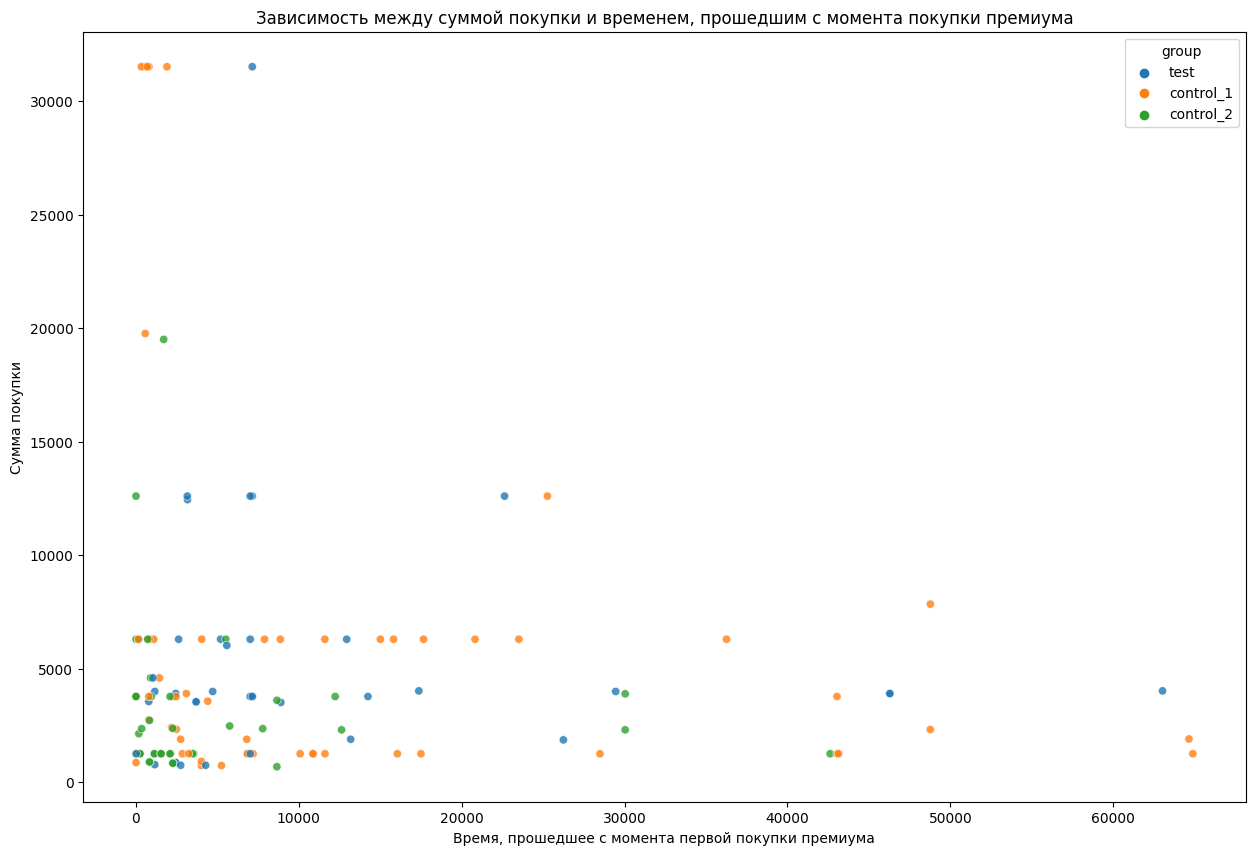

In [339]:
# x = время, прошедшее с момента первой покупки премиума
# y = сумма покупки
plt.figure(figsize=(15, 10))
plt.title(f'''Зависимость между суммой покупки и временем, прошедшим с момента покупки премиума''', fontsize=12)
plt.xlabel("Время, прошедшее с момента первой покупки премиума")
plt.ylabel("Сумма покупки")
sns.scatterplot(data=purchased_after_premium, x='interval_in_min', y='revenue', hue='group', alpha=.8);

И здесь я опять-таки не вижу каких-то очевидных различий между тестовой и двумя контрольными выборками. Прослеживается общая тенденция покупать много мелких недорогих услуг через недолгое время после покупки премиума. Чем дальше - тем меньше у пользователя желания вообще что-либо покупать, что вполне закономерно.  

---

А может ли изменение цены подписки влиять не на выбор других продуктов, *а на желание покупать что-либо вообще?* Далее я проверю, значимы ли различия между группами в соотношении купивших что-то повторно и ничего не купивших после покупки премиума. 

In [135]:
# Список тех, кто что-то купил после покупки premium_no_trial во время экперимента
purchased_after_premium_lst = purchased_after_premium.uid.unique().tolist()
# (список сделан на основе ранее созданного датафрейма)

In [136]:
# Записываюю в новый датафрейм всех, кто во время экперимента покупал premium_no_trial и их группу
new_df = df[['group','uid']].drop_duplicates(keep='first')

In [137]:
# В новом столбце для тех, кто после покупки премиума купил какой-либо другой продукт, ставлю единицу, остальным ноль
new_df['bought_smth_else'] = [1 if x in purchased_after_premium_lst else 0 for x in new_df.uid]

In [138]:
# На всякий случай проверю, все ли совпало
len(purchased_after_premium_lst) == new_df.bought_smth_else.sum()
# Да, всё ок

True

In [139]:
# Как выглядит датафрейм?
new_df.head()

,group,uid,bought_smth_else
2,test,892236423.0,1
5,test,892426491.0,0
11,test,891861048.0,1
15,test,892186941.0,1
21,test,891071157.0,0


In [140]:
crstab = (new_df.groupby(['group', 'bought_smth_else'], as_index=False)
          .agg({'uid':'count'}).pivot(index='group', columns='bought_smth_else'))
crstab

statistic, pvalue, dof, expected_freq = scipy.stats.chi2_contingency(crstab)
print(f'''statistic: {statistic}, pvalue: {pvalue}, dof: {dof}''')

uid    
bought_smth_else   0   1
group                   
control_1         33  24
control_2         39  23
test              33  12

statistic: 2.6566538818341625, pvalue: 0.26492011774326374, dof: 2


**Хи-квадрат** сильно выше порогового значения 0.05. Это говорит о том, что значимых различий между группами не найдено.
___

***Вывод по вопросу о выборе данных.*** Из всего вышесказанного, думаю, вполне логично заключить, что между покупкой разных типов подписки нет значимой связи. Иными словами, изменение цены подписки никак не повлияло на готовность платить за другие виды подписок у отдельного пользователя. А это значит, что **ARPPU** все же следует считать через сумму транзакций по `premium_no_trial`, а не по средней общей выручке за все продукты.

Теперь осталось отобрать данные для расчета ARPPU.

In [141]:
# Собираю данные для t-test(-а)

data_for_arppu = (transactions[(transactions.joined_at.dt.month >= 10) &
                    (transactions.paid_at_corrected.dt.month <= 12)] # период проведения теста
                     # только участники эксперимента, купившие премиум:
                     .query('country in @right_countries_lst & uid in @uid_bought_premium_lst &  payment_id in [68,147]') 
                     .groupby(['group', 'uid']).revenue.sum().reset_index())
data_for_arppu.head(3)

,group,uid,revenue
0,control_1,891607515.0,6292.0
1,control_1,891613833.0,1898.0
2,control_1,891616074.0,6292.0


На графике сразу видны сильные выбросы по всем трем группам, однако разброс значений у тестовой группы сильно больше, чем у контрольных:

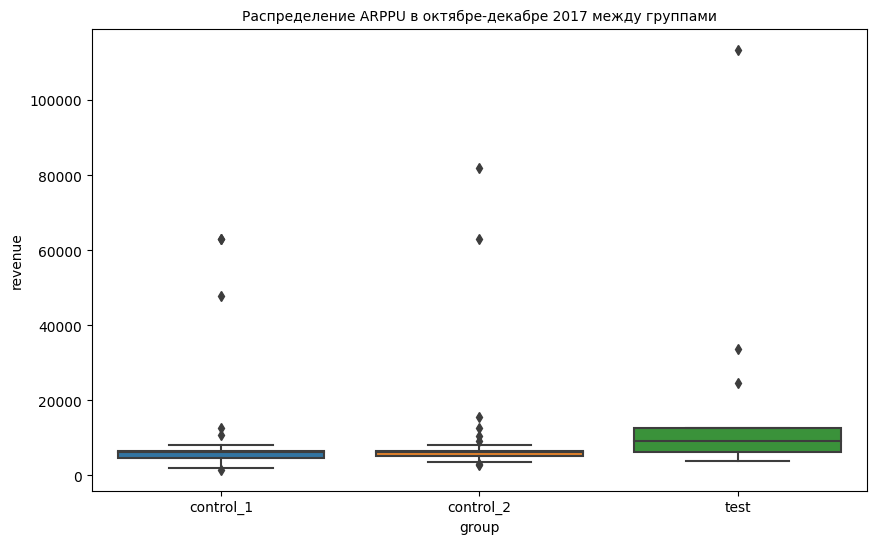

In [143]:
plt.figure(figsize=(10, 6))
plt.title(f'''Распределение ARPPU в октябре-декабре 2017 между группами''', fontsize=10)
sns.boxplot(data=data_for_arppu, 
           x='group', y='revenue');

In [323]:
# Количество наблюдений в каждой группе

data_for_arppu.groupby('group', as_index=False).revenue.count()

,group,revenue
0,control_1,57
1,control_2,62
2,test,45


Несмотря на то, что наблюдений по каждой группе очень мало, по объему выборок группы, в общем-то, сопоставимы. Проблему также могут создать сильные выбросы, которые подтягивают за собой среднее и часто смещают его (особенно на таких маленьких выборках, как у меня). Из-за всего этого у меня возникли опасения, сработает ли t-test правильно на моих данных. 

Поэтому, прежде чем что-то считать, я решила проверить, соблюдаются ли все допущения, а именно:
1. *гомогенность дисперсий* (не так важно, можно обойти через поправку - критерий Уэлча);
2. *нормальность распределения среднего*. 

In [145]:
# Проверяю на гомогенность дисперсий

pg.homoscedasticity(data_for_arppu, dv='revenue', group='group', method='levene', alpha=0.05)

,W,pval,equal_var
levene,0.3956,0.673929,True


Дисперсии одинаковы: первое требование выполнено. Критерий Уэлча не понадобится.

Теперь через **bootstrap** проверю нормальность распределения среднего.

In [146]:
n = 10000 # 10 тыс. симуляций

# Завожу списки для средних значений
a1_lst=[]
a2_lst=[]
b_lst=[]

for i in tqdm(range(n)):
    a1_lst.append(data_for_arppu.query('group=="control_1"').revenue.sample(frac=1, replace=True).mean())
    a2_lst.append(data_for_arppu.query('group=="control_2"').revenue.sample(frac=1, replace=True).mean())
    b_lst.append(data_for_arppu.query('group=="test"').revenue.sample(frac=1, replace=True).mean())

# Собираю все в один датафрейм
means = pd.DataFrame({'A1':a1_lst, 'A2':a2_lst, 'B':b_lst})
means.head(3)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 390.67it/s]


,A1,A2,B
0,8925.526316,6309.403226,12516.111111
1,5589.087719,9261.661290,9605.555556
2,7349.333333,7637.290323,12948.577778


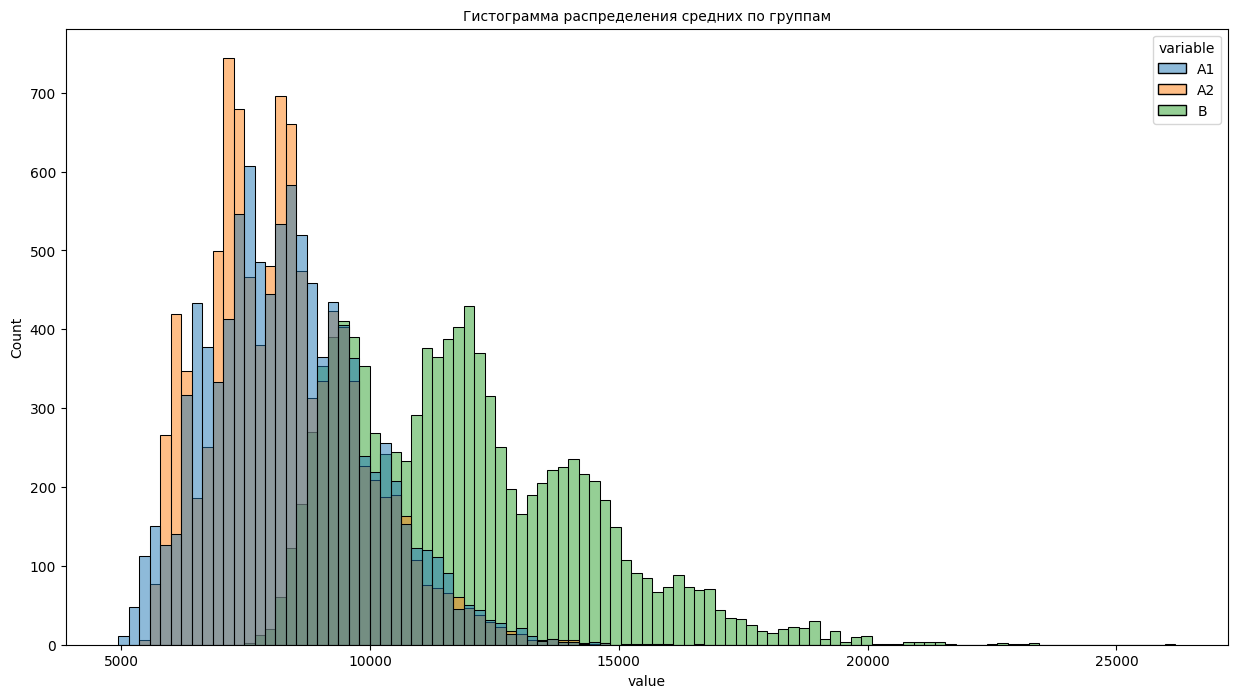

In [149]:
# Гистограмма распределения средних

plt.figure(figsize=(15,8))
plt.title(f'''Гистограмма распределения средних по группам''', fontsize=10)
sns.histplot(x='value', hue='variable', data=pd.melt(means));

На гистограмме уже сразу видно, что распределение средних всех трех групп точно не похоже на нормальное. 

Еще лучше отклонение от нормального распределения видно на графике `QQ-plot`:

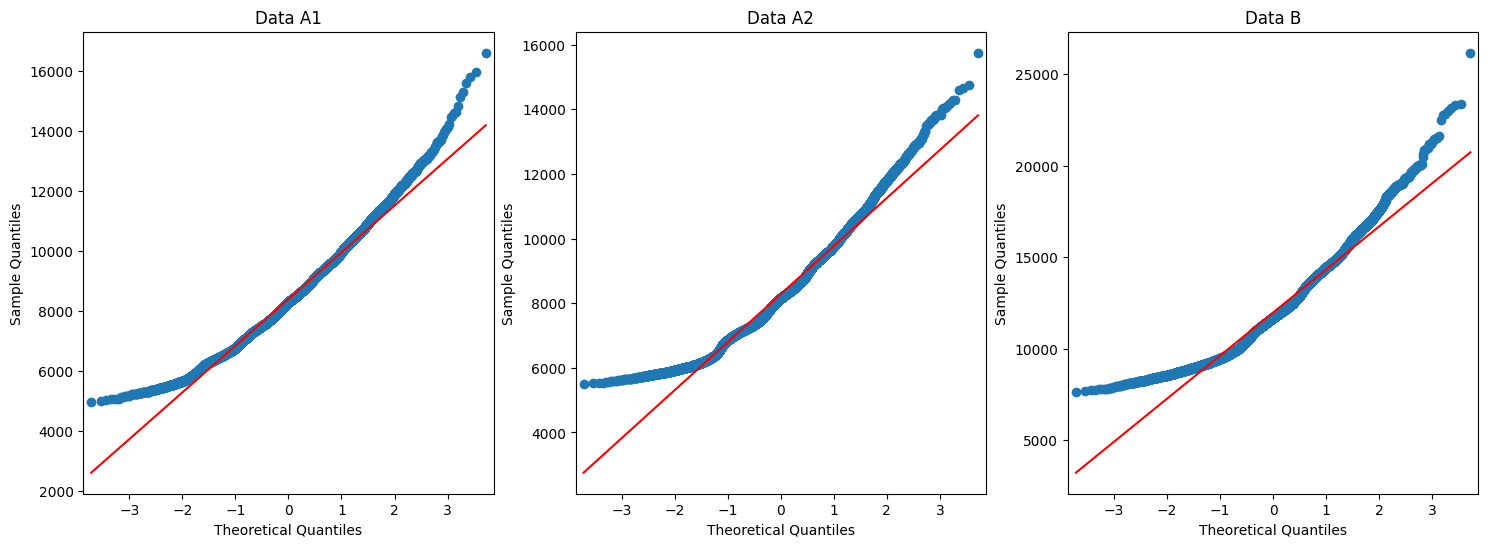

In [150]:
# QQplot

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))
ax1.set_title('Data A1')
ax2.set_title('Data A2')
ax3.set_title('Data B')
sm.qqplot(means['A1'], line='r', ax=ax1)
sm.qqplot(means['A2'], line='r', ax=ax2)
sm.qqplot(means['B'], line='r', ax=ax3);

Но проще всего нормальность распределения проверить через тест Шапиро-Уилка.

In [151]:
print(f'''Проверка на нормальность распределения (тест Шапиро-Уилка)
Значения p-value для
- контрольной группы 1: {scipy.stats.shapiro(a1_lst)[1]}
- контрольной группы 2: {scipy.stats.shapiro(a2_lst)[1]}
- тестовой группы:      {scipy.stats.shapiro(b_lst)[1]}''')

Проверка на нормальность распределения (тест Шапиро-Уилка)
Значения p-value для
- контрольной группы 1: 9.032843158500042e-33
- контрольной группы 2: 2.2621161109595522e-41
- тестовой группы:      0.0


Во всех трех распределениях значения p-value < 0.05, что отклоняет нулевую гипотезу о нормальности распределения. Это значит, что среднее в выборках рапределено ненормально и использовать t-test в данном случае опасно (он, я так понимаю, не работает с подобными распределениями).

Рассчитать ARPPU можно и через ***непараметрические критерии*** (например, здесь могут подойти bootstrap, перестановочный метод). Пусть критерий **bootstrap** и менее надежен по сравнению с тестом Стьюдента, зато его преимущество в том, что он не предъявляет требований к характеру распределений. Поэтому его можно сразу использовать без предварительных проверок. Достоверность результатов, полученных после бутсрэпа, определяется только качеством исходных данных (выборки репрезентативны, случайно засплитованны и отражают реальное положение дел). Вопрос о корректном сплитовании я сейчас застрагивать не стану, но в остальном, без доступа к реальным данным за прошлые периоды мне остается только надеяться, что столь малые выборки действительно репрезентативны. 

**Реализация метода.** У меня уже есть датафрейм с собранными значениями средних по 10 тысячам симуляций. Если средние по группам значимо не отличаются, то в доверительный интервал разности между этими средними попадет ноль.

**Гипотезы для А/А/B-теста:**
- $H_0$: статистически значимых различий нет (*в ДИ разницы средних попадет ноль*); 
- $H_1$: статистически значимые различия есть.

In [155]:
# Считаю разницу между средними, добавляю столбцы в таблицу
means['diff_A1_A2'] = means.A1 - means.A2
means['diff_A1_B']  = means.A1 - means.B
means['diff_A2_B']  = means.A2 - means.B

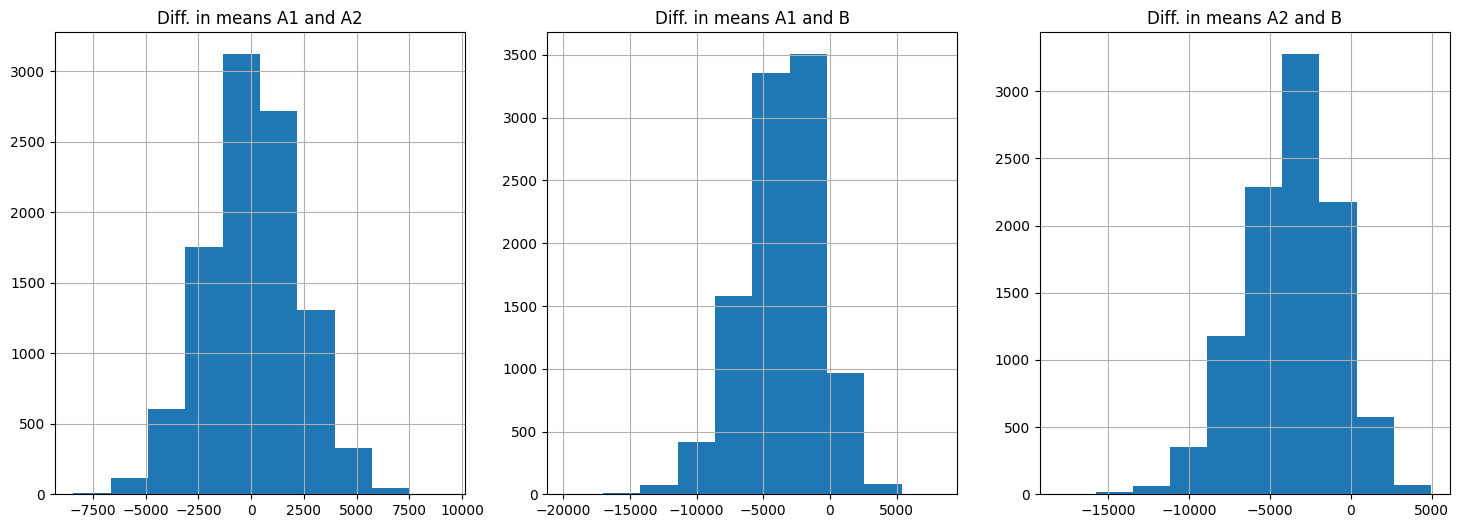

In [167]:
# Визуализация:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))
ax1.set_title('Diff. in means A1 and A2')
ax2.set_title('Diff. in means A1 and B')
ax3.set_title('Diff. in means A2 and B')
means.diff_A1_A2.hist(ax=ax1)
means.diff_A1_B.hist(ax=ax2)
means.diff_A2_B.hist(ax=ax3);

Распределение всех разностей средних на всех гистограммах похоже на нормальное, пусть и имеет огромный размах. Почти уверена, что виной всему сильные выбросы в исходных маленьких выборках, которые сильно оттащили среднее наверх. Также интересно заметить, что в обоих случаях, когда тестовые средний вычитались из контрольных, распределение сдвинуто влево относительно нуля.

Эта особенность лучше видна на боксплоте ниже:

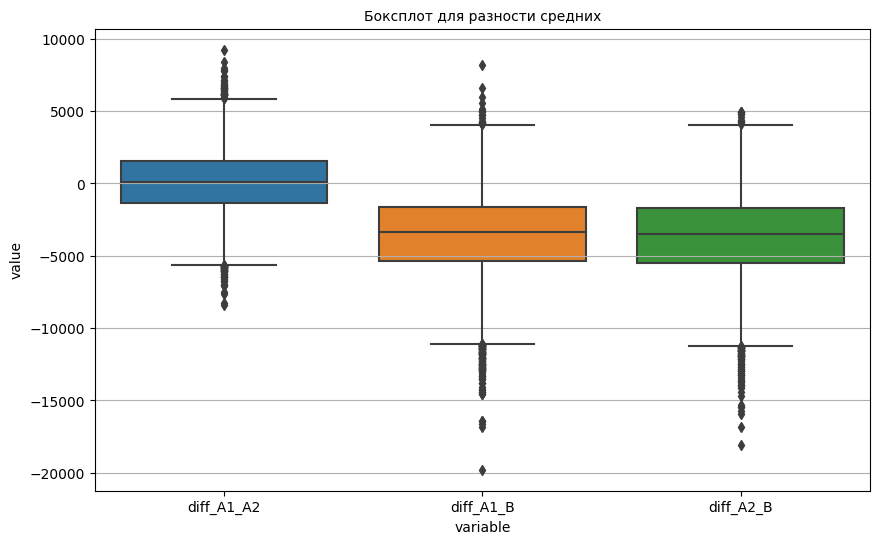

In [295]:
plt.figure(figsize=(10,6))
plt.title(f'''Боксплот для разности средних''', fontsize=10)
plt.grid(axis='both')
sns.boxplot(data=pd.melt(means[['diff_A1_A2','diff_A1_B','diff_A2_B']]), x='variable', y='value');

Большой размах дает основания предположить, что у всех трех распределений будут высокие стандартные ошибки. 

In [311]:
print(
f'''Стандартные ошибки для разностей средних (1) и среднее для распределений (2):
А1 и А2: (1){means.diff_A1_A2.sem()}, (2){means.diff_A1_A2.mean()};
А1 и B:  (1){means.diff_A1_B.sem()}, (2){means.diff_A1_B.mean()};
А2 и B:  (1){means.diff_A2_B.sem()}, (2){means.diff_A2_B.mean()}''')

Стандартные ошибки для разностей средних (1) и среднее для распределений (2):
А1 и А2: (1)21.72026931461205, (2)108.55515548953028;
А1 и B:  (1)28.795930443242366, (2)-3578.9889808187136;
А2 и B:  (1)28.59166037982967, (2)-3687.5441363082437


Высокие стандартные ошибки подтверждают наличие шума в исходных данных и заставляют сомневаться в надежности полученных результатов. Что ж, осталось только проверить, есть ли реальные различия между средними. 

In [320]:
print(
f'''Доверительные интервалы для разностей средних:
А1 и А2: {sms.DescrStatsW(means['diff_A1_A2']).tconfint_mean(alpha=0.05)};
А1 и B:  {sms.DescrStatsW(means['diff_A1_B']).tconfint_mean(alpha=0.05)};
А2 и B:  {sms.DescrStatsW(means['diff_A2_B']).tconfint_mean(alpha=0.05)}.''')

Доверительные интервалы для разностей средних:
А1 и А2: (65.97905613283159, 151.13125484622907);
А1 и B:  (-3635.4348000607106, -3522.5431615767175);
А2 и B:  (-3743.5895451138185, -3631.4987275026688).


Доверительные интервалы ни одного из рассматриваемых распределений разностей средних не включают в себя ноль, что **подтверждает альтернативную гипотезу во всех трех случаях.** Далее я разберу этот результат сначала к контексте с А/А, потом в А/В эксперименте. 

Подтверждение альтернативной гипотезы ***в случае с А/А-тестом может говорить о следующем:***

 **Предположение 1.** Система сплитования работала некорректно, поэтому данные по А/А-группам распределились неслучайным образом (что, собственно, и показал проведенный тест). *К этому вопросу я вернусь в Заключении.*
 
 **Предположение 2.** Полученные выборки по А/А группам нерепрезентативны. Может, данных слишком мало, а может быть, они не охватывают какую-то неочевидную сезонность. В любом случае, нерепрезентативность групп говорит о том, что реальное распределение ГС данные выборки не отражают. 
 
И, наконец, результаты А/В-теста, при наличии значимых различий в А/А-тесте, мне кажется, оценивать в принципе неверно. Поэтому вопрос об изменении ARPPU остается открытым.

# Заключение
***Если на вопрос об успешности эксперимента в целом должен быть однозначный ответ, то он, скорее, отрицательный.*** Далее постараюсь по пунктам обосновать свою позицию. 

**п.1.** Неполнота данных в исходных датафреймах ограничила возможность оценить реальную конверсию в покупку премиум-подписки. В практической части в комментариях к тесту на конверсию я добавила небольшую заметку об этом, но сейчас хочу раскрыть тезис подробнее. Да, в `users` есть данные `is_premium` и `was_premium`, но без хронологического контекста совершенно непонятно, что с этими данными делать. И поскольку эксперимент ограничен только новыми пользователями, сама идея использовать `is_premium` и `was_premium` для подсчета конверсии в контексте данной задачи мне не кажется правильной. Из-за этого задачу пришлось сузить и посчитать конверсию в покупку премиума только для платящих пользователей. Результаты оказались незначимыми (*хоть экперимент не был успешен не из-за этого*).

**п.2.** Учитывая различные ошибки в данных, на которые было указано в практической части, меня волновал вопрос о корректности работы системы сплитования. В работу это не вошло, но я посчитала FPR для итоговых выборок контрольных групп (по выручке в целом). Хоть значения и получилось маленьким (FPR чуть больше нуля), но гистограмма распределения `p-value` не дает равномерного распределения. При сравнении с тестовой группой FPR тоже работает нормально (для `control_1` и `control_2` при сравнении с тестовой выборкой FPR стабильно выше порога 0.05). Впрочем, несмотря на то, что FPR < 0.05 для контрольных групп - уже сам по себе хороший результат, сомнения у меня вызывает гистограмма, которая, по идее, должна быть распределена равномерно, но на деле выглядит по-другому (*см.Приложение*). Собственно, если данные действительно распределяются по группам неслучайно, то вся вышеприведенная работа не имеет смысла.

**п.3.** Слишком маленький объем выборок. Чтобы данные соотвествовали условиям задачи, мне пришлось основательно их переработать и выкинуть большую их часть. В итоге получились небольшие по объему выборки с сильными выбросами, которые не прошли тест на нормальность распределения среднего, из-за чего одну из выбранных метрик пришлось проверять другим, менее мощным способом. (*Хотя, возможно, это отчасти и моя вина тоже - не стоило так много данных отбрасывать*). Но даже если не фильтровать данные, проблема с выбросами останется.

**п.4.** При расчете ARPPU через bootstrap А/А-тест показал значимые различия между средними. Этот факт снова ставит вопрос о корректности сплитования, затронутый в п.2, но он так же может говорить о малой мощности самого метода на этих данных или свидетельствовать о нерепрезентативности выборок в общем. В любом случае, результаты bootstrap(-а) не приближают меня к положительной оценке этого A/A/B-теста.

**п.5.** В дополнение к п.4 хотелось бы добавить, что я в принципе ничего не знаю о мощности проводимых тестов. Мощность, как и необходимый объем выборок, *рассчитывается заранее,* а не постфактум. Так же и тесты необходимо выбирать *до эксперимента*, еще не имея выборок на руках. Иначе есть риск потратить много денег на эксперимент, который ничего не даст. А при отсутсвии заранее созданного дизайна как такового, любой А/В-тест сложно назвать успешным.


*Далее будут две небольшие заметки, касающиеся содержания датафреймов вообще. Они не подкрепляют и не опровергают написанное в пунктах выше, просто дают лучшее представление о данных, с которыми пришлось работать.*

> Неполнота с одной строны компенсируется избыточностью данных с другой. Например, зачем были даны `visit_days` в датафреймах `users`? Если идея в том, чтобы посчитать Retention, то в `users` это бесполезно, т.к., повторюсь, нет дат регистрации, а в `transactions` это делать тоже бесполезно, т.к. будут учтены далеко не все пользователи. И даже есть посчитать Retention, то как его сравнивать между группами? Все это я веду к тому, что в датасетах есть абсолютно бесполезные столбцы, которые сбивают с толку. 

> Дубликаты и ошибки в данных тоже были проблемой. Из-за дублирующихся строк `total_revenue` для некоторых пользователей посчитался некорректно. В моем случае на небольшом объеме данных это не представляет угрозы, но если `total_revenue` всегда считается так, то расхождения с реальностью в будущем будут уже серьезными. Вторая и, на мой взгляд, более странная ошибка - неправильное считывание даты в некоторых строках в `paid_at`. Если возникла проблема с ноябрем (11-й месяц стал числом), то точно также могут перепутаться, например, 6-е мая и 5-е июня, и если пользователь зарегистрирован раньше этих дат, то ошибку отловить будет очень сложно. 

### Приложение. Расчёт FPR
*Этот раздел я решила оставить в качестве приложения уже после написания заключения. Он идет как иллюстрация к проблеме с FPR, описанной в пункте 2 выше.*

In [328]:
# Функция для расчета FPR

def calculate_FPR (data1, data2, 
                   n_simulations = 10000, 
                   sample_size = 40, 
                   t_test_equal_var = False,
                   show_chart=True):
    
    p_value_list = []

    # Запускаю симуляции
    for i in tqdm(range(n_simulations)):
        s1 = data1.sample(sample_size, replace = False).values
        s2 = data2.sample(sample_size, replace = False).values
        p_value_list.append(scipy.stats.ttest_ind(s1, s2, equal_var = t_test_equal_var)[1]) # сохраняем pvalue
    
    # Отрисовка графика
    fig = plt.figure(figsize=(8,6))
    sns.histplot(p_value_list, bins=50)
    plt.fill([0,1,1,0],[n_simulations/50,n_simulations/50, 0, 0],'b', alpha=.2)
    if show_chart == True:
        plt.show(fig)
    else: plt.close(fig)

    # Вывожу количество ложноположительных случаев
    return(print('FPR:', sum(np.array(p_value_list) <0.05) / n_simulations))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1720.37it/s]


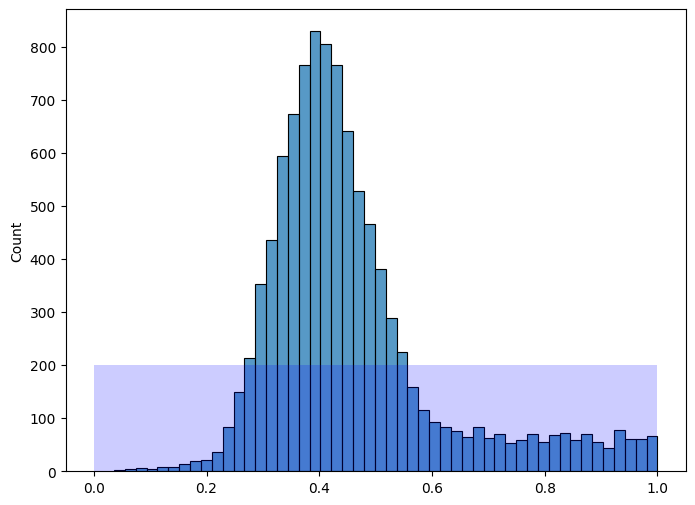

FPR: 0.0003


In [332]:
# FPR для контрольных групп
calculate_FPR(data1=transactions_october.query('group=="control_1"').total_revenue_corrected, 
             data2=transactions_october.query('group=="control_2"').total_revenue_corrected, 
             sample_size=80, t_test_equal_var=False)

In [336]:
# Для контрольной-1 и тестовой
calculate_FPR(data1=transactions_october.query('group=="control_1"').total_revenue_corrected, 
             data2=transactions_october.query('group=="test"').total_revenue_corrected, 
             sample_size=80, t_test_equal_var=False, show_chart=False)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1734.27it/s]

FPR: 0.2202


In [337]:
# Для контрольной-2 и тестовой
calculate_FPR(data1=transactions_october.query('group=="control_2"').total_revenue_corrected, 
             data2=transactions_october.query('group=="test"').total_revenue_corrected, 
             sample_size=80, t_test_equal_var=False, show_chart=False)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1711.61it/s]


FPR: 0.7852
